In [25]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
df = pd.read_csv("cryptos.csv", index_col=0, parse_dates=True)
df.sort_index(inplace=True)
tickers = ["BTCUSDT", "ETHUSDT", "XRPUSDT", "SOLUSDT", "SUIUSDT", "UNIUSDT", "AAVEUSDT"]
lookback = 12
n_top = 1
momentum = df[tickers].pct_change(periods=lookback)
### -------------------------------------------- ###
# raw_mom = df[tickers].pct_change(lookback)
# volatility = df[tickers].pct_change().rolling(lookback).std()
# momentum = raw_mom / volatility
### -------------------------------------------- ###

In [26]:
def generate_signals(row):
    positive = row[row > 0]
    if positive.empty:
        return pd.Series(0, index=row.index)
    top_assets = positive.nlargest(n_top).index
    signals = pd.Series(0, index=row.index)
    signals[top_assets] = 1
    return signals
signals = momentum.apply(generate_signals, axis=1)
signals = signals.shift(1)

invest_flag = signals.sum(axis=1) > 0
returns = df[tickers].pct_change()
strategy_returns = signals * returns

In [27]:
def compute_portfolio_return(row):
    current_signals = signals.loc[row.name]
    selected = current_signals[current_signals == 1].index
    if len(selected) == 0:
        return 0
    return row[selected].mean()
portfolio_returns = strategy_returns.apply(compute_portfolio_return, axis=1)
portfolio_returns = returns.apply(compute_portfolio_return, axis=1)
portfolio_returns = portfolio_returns.fillna(0)
cumulative_returns = (1 + portfolio_returns).cumprod()

Final Return: 21.98%
Max Drawdown: -31.96%


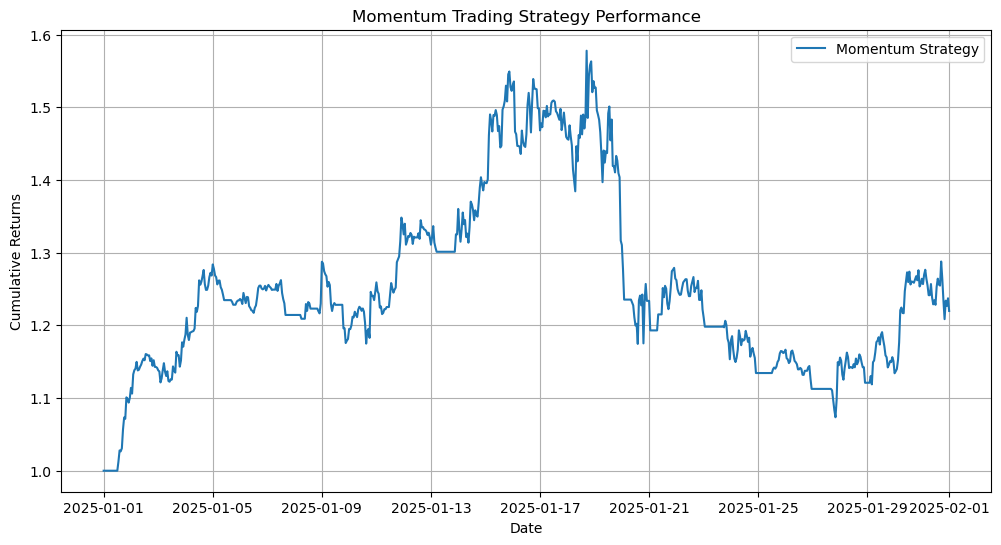

In [28]:
final_return = cumulative_returns.iloc[-1] - 1
def max_drawdown(cum_returns):
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    return drawdown.min()
drawdown = max_drawdown(cumulative_returns)

print(f"Final Return: {final_return*100:.2f}%")
print(f"Max Drawdown: {drawdown*100:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns, label="Momentum Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Momentum Trading Strategy Performance")
plt.legend()
plt.grid(True)
plt.show()

# TestLoop

In [59]:
results = []
for i in range(1, 25):
    momentum = df[tickers].pct_change(periods=i)
    signals = momentum.apply(generate_signals, axis=1)
    signals = signals.shift(1)
    returns = df[tickers].pct_change()
    strategy_returns = signals * returns
    portfolio_returns = strategy_returns.apply(compute_portfolio_return, axis=1)
    portfolio_returns = portfolio_returns.fillna(0)
    cumulative_returns = (1 + portfolio_returns).cumprod()

    final_return = cumulative_returns.iloc[-1] - 1
    print("lookback - ", i)
    print(f"Final Return: {final_return*100:.2f}%")
    results.append((i, final_return))
results_df = pd.DataFrame(results, columns=["Lookback", "Final Return"])

lookback -  1
Final Return: -21.37%
lookback -  2
Final Return: 5.31%
lookback -  3
Final Return: 11.77%
lookback -  4
Final Return: -7.31%
lookback -  5
Final Return: 1.98%
lookback -  6
Final Return: -7.95%
lookback -  7
Final Return: 10.23%
lookback -  8
Final Return: 25.69%
lookback -  9
Final Return: 46.22%
lookback -  10
Final Return: 5.78%
lookback -  11
Final Return: 35.09%
lookback -  12
Final Return: 21.98%
lookback -  13
Final Return: 31.62%
lookback -  14
Final Return: 47.23%
lookback -  15
Final Return: 52.77%
lookback -  16
Final Return: 57.73%
lookback -  17
Final Return: 84.76%
lookback -  18
Final Return: 60.62%
lookback -  19
Final Return: 48.18%
lookback -  20
Final Return: 49.85%
lookback -  21
Final Return: 83.85%
lookback -  22
Final Return: 37.39%
lookback -  23
Final Return: 51.71%
lookback -  24
Final Return: 44.37%


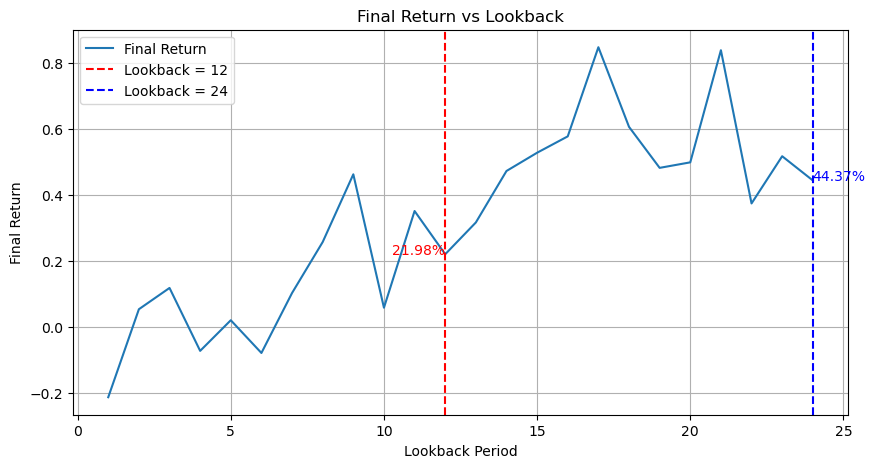

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(results_df["Lookback"], results_df["Final Return"], label="Final Return")

plt.axvline(x=12, color='red', linestyle='--', label='Lookback = 12')
plt.axvline(x=24, color='blue', linestyle='--', label='Lookback = 24')

val_12 = results_df.loc[results_df["Lookback"] == 12, "Final Return"].values
val_24 = results_df.loc[results_df["Lookback"] == 24, "Final Return"].values
if len(val_12) > 0:
    plt.text(12, val_12[0], f"{val_12[0]*100:.2f}%", color='red', ha='right')
if len(val_24) > 0:
    plt.text(24, val_24[0], f"{val_24[0]*100:.2f}%", color='blue', ha='left')
plt.xlabel("Lookback Period")
plt.ylabel("Final Return")
plt.title("Final Return vs Lookback")
plt.grid(True)
plt.legend()
plt.show()